# 5.4 Visualizing what convnets learn
The representations learned by convnets are representations of visual concepts. A wide array of techniques have been developed for visualizing and interpreting these representations:
 - ***Visualizing intermediate convnet outputs (intermediate activations)*** - Useful for understanding how a series of convnet layers transform their input.
 - ***Visualizing convnet filters*** - Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to.
 - ***Visualizing heatmaps of class activation in an image*** - Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images.
 
## 5.4.1 Visualizing intermediate activations
Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network. This lets us see how the image is seen by different filters in the network. We want to view feature maps with three dimensions: width, height, and depth (channels).

In [1]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Next, we'll get an input image - a picture of a cat that was not used to train the network.

In [2]:
img_path = '/Volumes/RobStorage/Desktop/Python_Practice/DL_with_Python/data/cats_and_dogs_small/test/cats/cat.1700.jpg'

In [3]:
# Preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

# shape is (1, 150, 150, 3)
print img_tensor.shape

(1, 150, 150, 3)


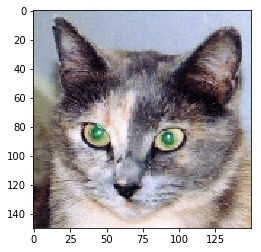

In [4]:
# Display the picture
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

To extract the feature map we want to look at, we will create a Keras model that takes batches of images as inputs, and outputs the activations of all convolution and pooling layers. To do this, we'll use the Keras class **`Model`**, which is instantiated with two arguments - an input tensor and an output tensor. This is similar to the `Sequential` model, but **`Model`** allows for models with multiple outputs, unlike `Sequential`.

In [7]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

When fed an image as input, this model returns multiple outputs, unlike previous models which returned only a single output. A model can actually have any number of inputs and outputs. The model we are working on has 1 input and 8 outputs: one output per layer activation. 

In [8]:
# Get a list of 5 numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)

In [9]:
# Activation of first convolution layer for cat image
first_layer_activation = activations[0]
print first_layer_activation.shape

(1, 148, 148, 32)


So the output from this layer is a 148 x 148 feature map with 32 channels.

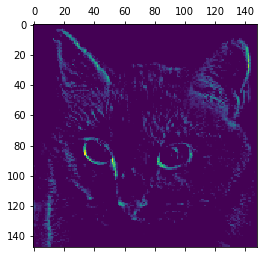

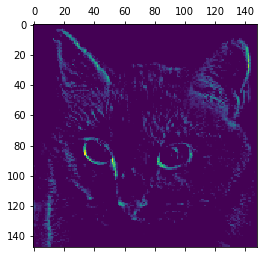

In [15]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis');
plt.show()

It appears that this channel encodes a diagonal edge detector. Let's see the seventh channel.

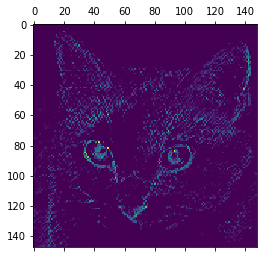

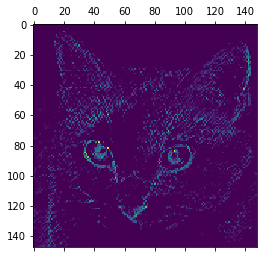

In [17]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')
plt.show()

This one looked quite useful to encode cat eyes. At this point, let's plot a complete visualization of all activations in the network. We will extract and plot every channel in each eight activation maps, and we'll stack the results in one big image tensor, with channels stacked side by side.

In [22]:
%matplotlib inline

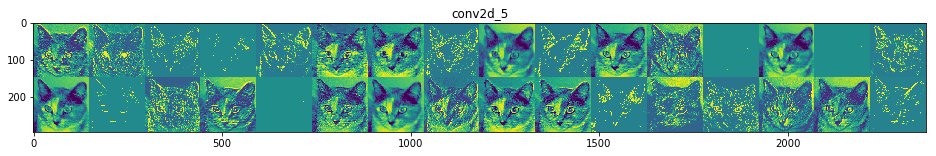

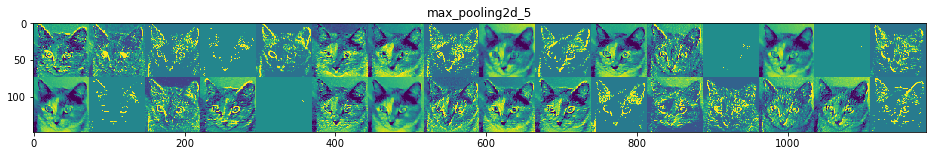

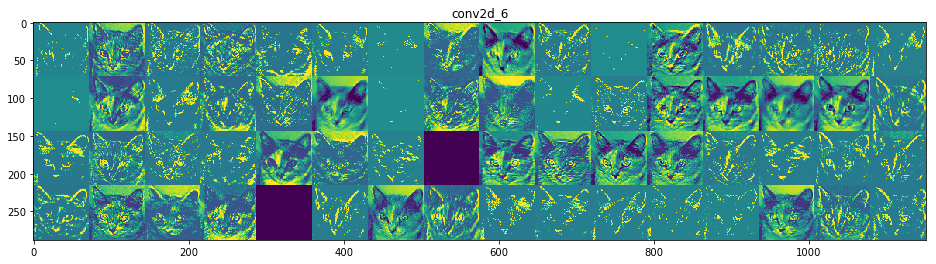

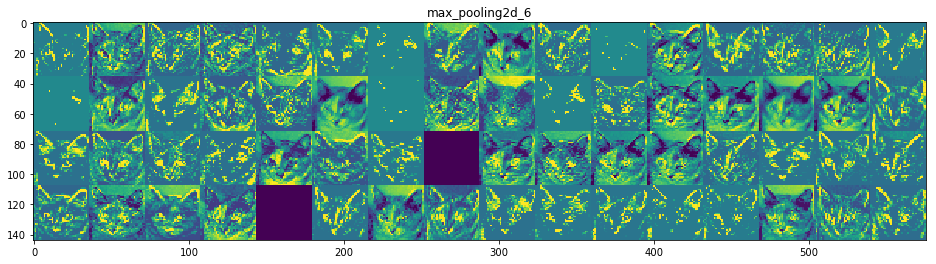

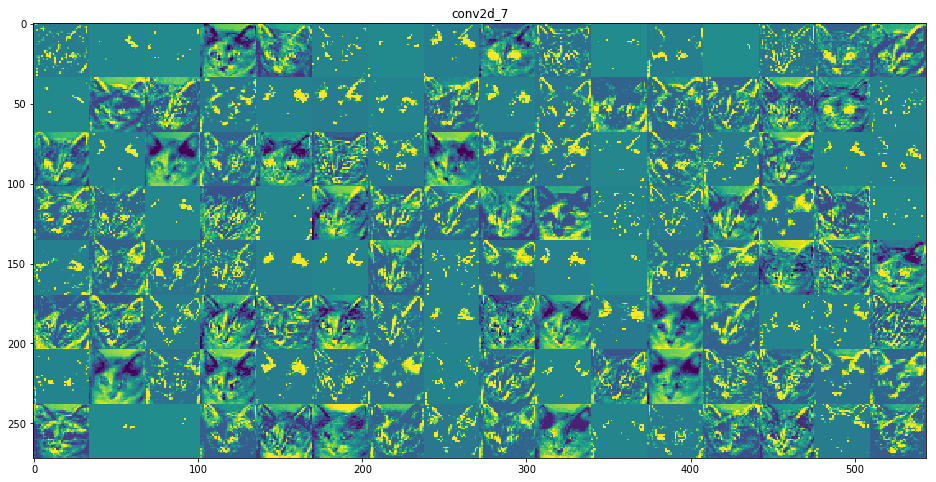

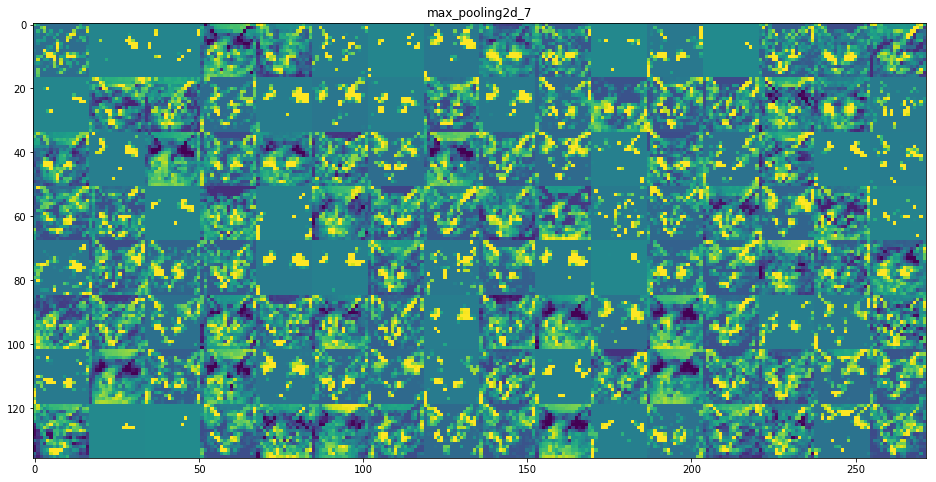

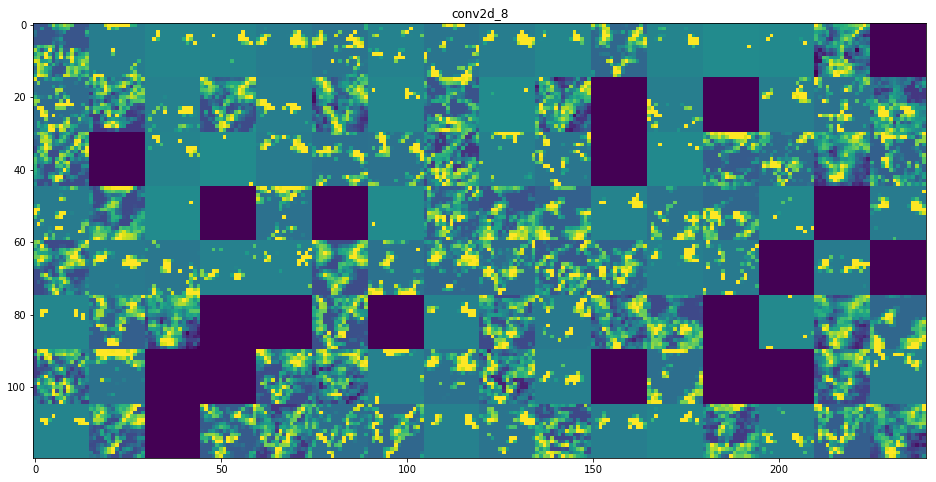

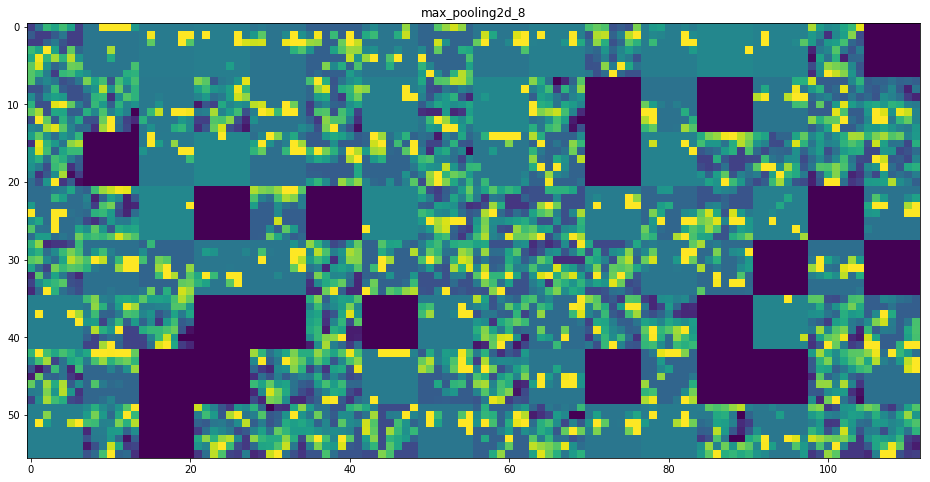

In [23]:
# names of layers so we can have them as part of the plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

# display the feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # number of features
    n_features = layer_activation.shape[-1]
    
    # feature map has shape (I, size, size, n_features)
    size = layer_activation.shape[1]
    
    # tile activation channels into matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    # tile each filter into big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    

Let's break down what we see here:
 - The first layer acts as a collection of various edge detectors. At this stage, the activations retain almost all of the information present in the initial picture.
 - As we go deeper, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as "cat ear" and "cat eye". Higher representations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
 - The sparsity of the activations increases with the depth of the layer: in the first layer, all filters are activated by the input image; but int he later layers, more and more filters are blank. This means the pattern encoded by the filter isn't found in the input image.
 
We have just derived an important universal characteristic of the representations learned by deep neural networks: the features extracted by a layer become increasingly abstract with the depth of the layer. The activations of higher layers carry less and less information about th especific input being seen, and more and more information about the target (class of image: cat or dog). 

The way humans and animals perceive the world is by observing a scene for a few seconds, and remembering which abstract objects were present in the image (bicylce, tree, etc.) but can't remember the specific appearance of these objects.

## 5.4.2 Visualizing convnet filters
Another good way to inspect the filters learned by the convnets is to display the visual patter that each filter is supposed to respond to. This can be done with *gradient ascent in input space*: applying a *gradient descent* to the value of the input image of a convnet so we maximize the response of a specific filter, starting from a blank input image. 

This process is simple: we build a loss function that maximizes the value of a given filter in a given convolution layer, and then we'll use stochastic gradient descent to adjust the values of the input image so we can maximize the activation value.

In [24]:
from keras.applications import VGG16
from keras import backend as K

In [40]:
model = VGG16(weights = 'imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

To implement gradient descent, we'll need the gradient of the loss with respect to the model's input. 

In [41]:
# call to gradients returns list of tensors
grads = K.gradients(loss, model.input)[0]

A trick to help the gradient-descent process go smoothly is to normalize the gradient tensor by dividing it by its L2 norm (square root of the average of the square of the values in the tensor). This ensures that the magnitude of the updates done to the input image is always within the same range.

In [42]:
# Gradient normalization trick
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) #add 1e-5 so we dont divide by 0

Now we need a way to compute the value of the loss tensor and the gradient tensor.

In [43]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [44]:
# Define Python loop to do stochastic gradient descent
# starts with gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1. #Magnitude of each gradient update
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value * step

The resulting image tensor is a floating-point tensor of shape (1, 150, 150, 3), with values that may not be integers within [0, 255]. Because of this, we need to postprocess this tensor to turn it into a displayable image.

In [45]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Now we have all the pieces! Let's put them together into a function that takes a layer name and filter index as its input, and returns a valid image tensor representing the pattern that maximizes the activation of the specified filter.

In [46]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

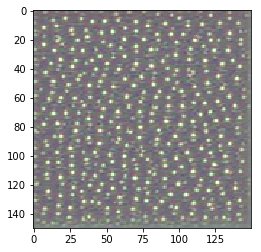

In [47]:
plt.imshow(generate_pattern('block3_conv1', 0))

It seems this filter is responsive to a polka-dot pattern. Now we can start visualizing every filter in every layer.

block1_conv1


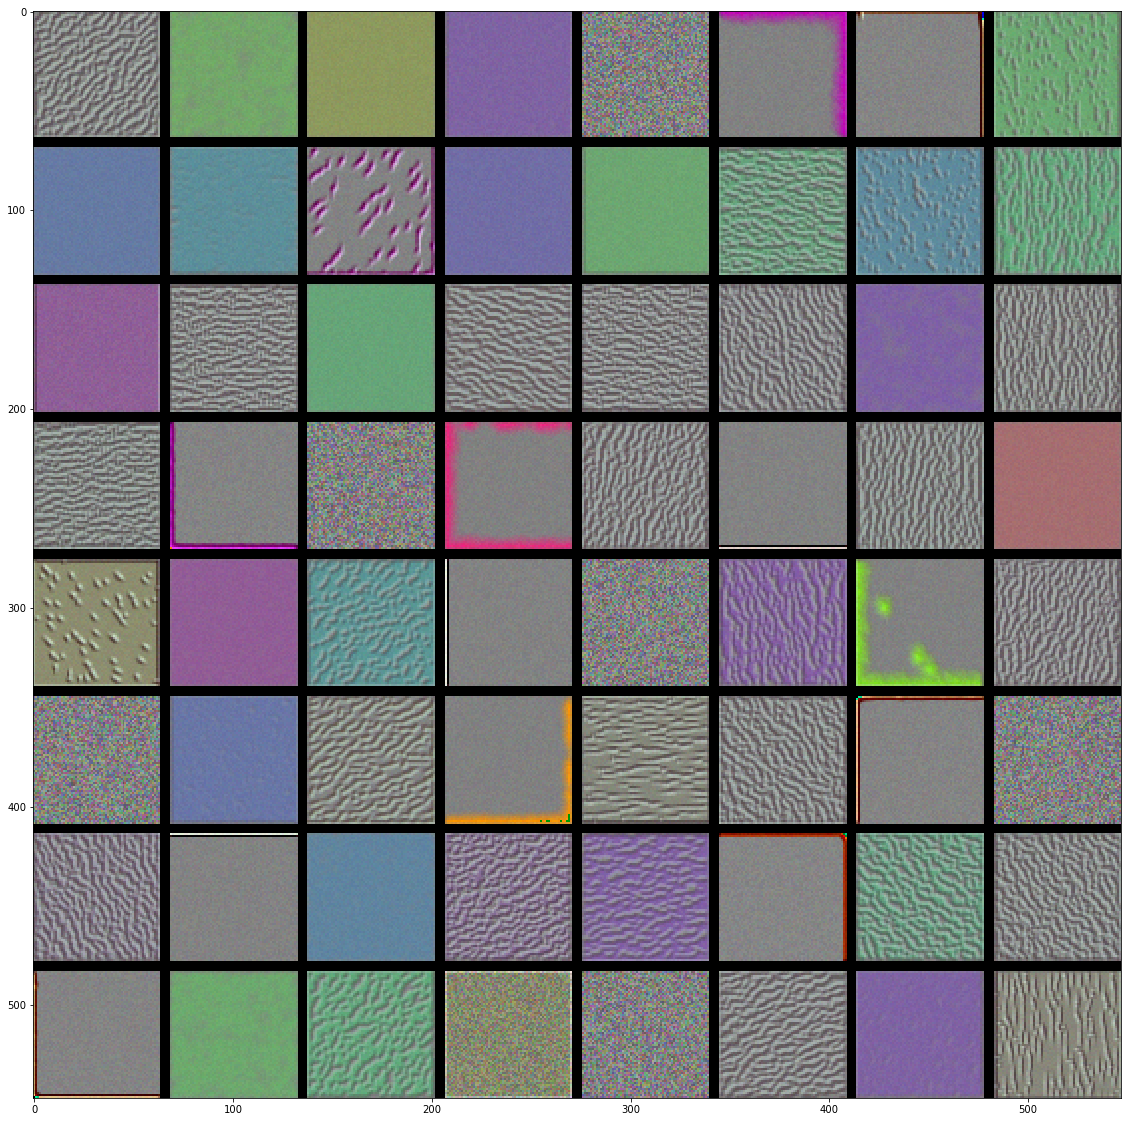

In [48]:
layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size = size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

print layer_name
plt.figure(figsize=(20, 20))
plt.imshow(results)

These filter visualizations tell us a lot about how convnet layers see the world: each layer in a convnet learns a collection of filters such that their inputs can be expressed as a combination of the filters. This is similar to how the Fourier transformation decomposes signals onto a bank of cosine functions. The filters in these convnet filter banks get increasingly complex and refined as we go higher in the model:
 - The filters from the first layer in the model (block1_conv1) encode simple directional edges and colors.
 - The filters from block2_conv2 encode simple textures made from contations of edges and colors.
 - The filters in higher layers begin to resember textures found in natural images: feathers, eyes, leaves, and so on.
 
## 5.4.3 Visualizing heatmaps of class activation
Now we will introduce another visualization technique that is useful for understanding which parts of a given images led a convnet to its final classification decision. This is useful for debugging the decision process of a convnet, particularly in classification.

This category of techniques is called *class activation map* (CAM) visualization, and it consists of producing heatmaps of class activations over input images. For example, given an image into a dogs-vs-cats convnet, CAM visualization allows you to generate a heatmap for the class "cat" indicating how cat-like parts of the image are, and another heatmap for the "dog" class.

This process consists of taking the output feature map of a convolution layer, given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the channel.

In [35]:
from keras.applications.vgg16 import VGG16

553418752/553467096 [============================>.] - ETA: 0s

In [58]:
model = VGG16(weights='imagenet')

Let's work with an image of two elephants (below). We will convert this image into something the VGG16 model can read: the model was trained on 224 x 244 images. We need to load the image, resize it to 224 x 244, convert it to a Numpy `float32` tensor, and apply the preprocessing rules.

![elephants](images/creative_commons_elephant.jpg)

In [60]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'images/creative_commons_elephant.jpg'

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)

x = preprocess_input(x)

In [61]:
# run pretrained network on image and decode its prediction vector
preds = model.predict(x)
print "Predicted:", decode_predictions(preds, top=3)[0]

Predicted:Downloading data from https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
16384/35363 [============>.................] - ETA: 0s [(u'n02504458', u'African_elephant', 0.90942073), (u'n01871265', u'tusker', 0.086183183), (u'n02504013', u'Indian_elephant', 0.0043545808)]


The top 3 predictions for this image are:
 - African elephant (90.9% probability)
 - Tusker (8.62% probability)
 - Indian elephant (0.44% probability)

In [62]:
np.argmax(preds[0])

386

The entry in the prediction vector that was maximally activated is the one corresponding to the "African elephant" class, at index 386.

To visualize which parts of the image are the most African elephant-like, let's set up the Grad-CAM process.

In [64]:
african_e66lephant_output = model.output[:, 386]

last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_e66lephant_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)

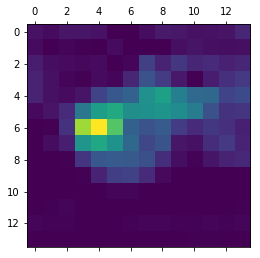

In [65]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [66]:
import cv2

img = cv2.imread(img_path)                                                 

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))                

heatmap = np.uint8(255 * heatmap)                                          

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)                     

superimposed_img = heatmap * 0.4 + img                                     

cv2.imwrite('images/elephant_cam.jpg', superimposed_img)

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

ImportError: numpy.core.multiarray failed to import